# KAGGLE - TITANIC

This notebook tackles the Titanic Kaggle.

----

<a id='Summary'></a>

[0. Data & packages](#section0)

[1. Useful functions](#section1)

[2. Pre-processing](#section2)

[3. EDA & FE](#section3)

[4. Modeling & Evaluation](#section4)

----

<a id='section0'></a>
# 0. Data & packages
<a href='#Summary'>Haut de page</a>

In [21]:
import warnings

import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, make_scorer

import xgboost as xgb

import pickle


In [22]:
RANDOM_STATE = 42

In [23]:
df = pd.read_csv('./DATA/train.csv')

<a id='section1'></a>
# 1. Useful functions
<a href='#Summary'>Haut de page</a>

In [24]:
# Useful functions
def feature_names(sklearn_feature_name_output, df):
    """
    This function takes the output from the .get_feature_names() method on the PolynomialFeatures 
    instance and replaces values with df column names to return output such as 'Col_1 x Col_2'

    sklearn_feature_name_output: The list object returned when calling .get_feature_names() on the PolynomialFeatures object
    df: Pandas dataframe with correct column names
    """
    cols = df.columns.tolist()
    feat_map = {'x'+str(num):cat for num, cat in enumerate(cols)}
    feat_string = ','.join(sklearn_feature_name_output)
    for k,v in feat_map.items():
        feat_string = re.sub(fr"\b{k}\b",v,feat_string)
    return feat_string.replace(" "," x ").split(',')

def compute_score(clf, X, y):
    """
    This function evaluates clf on data by taking the mean of 5-fold CV
    """

    cval = cross_val_score(clf, X, y, cv = 5)

    return np.mean(cval)
    

<a id='section2'></a>
# 2. Pre-processing
<a href='#Summary'>Haut de page</a>

In [25]:
df.shape

(891, 12)

In [26]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [27]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [28]:
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [29]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a id='section3'></a>
# 3. EDA & FE
<a href='#Summary'>Haut de page</a>

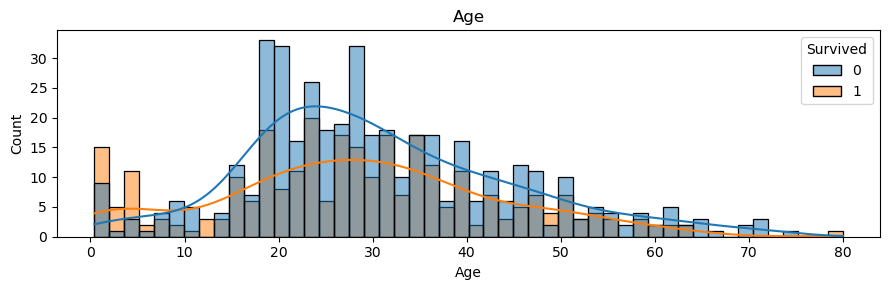

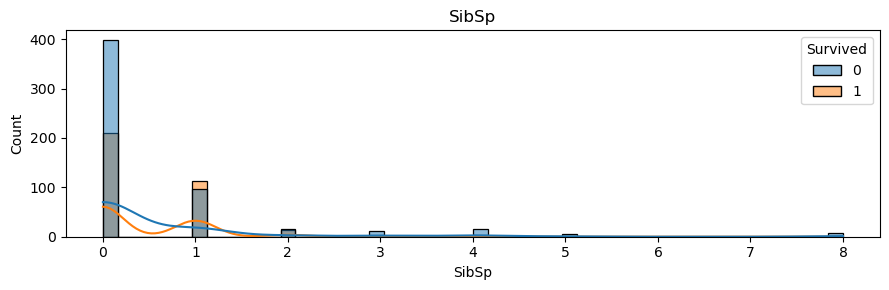

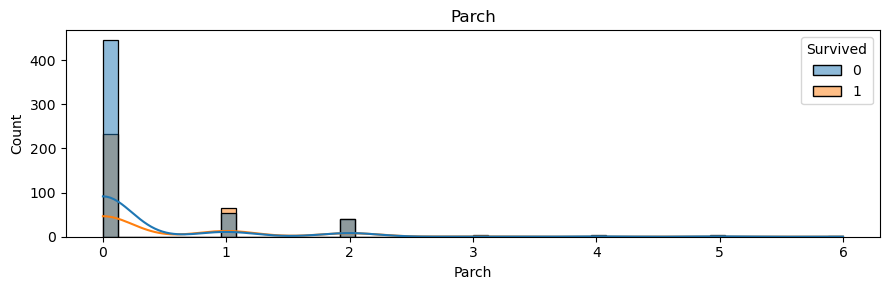

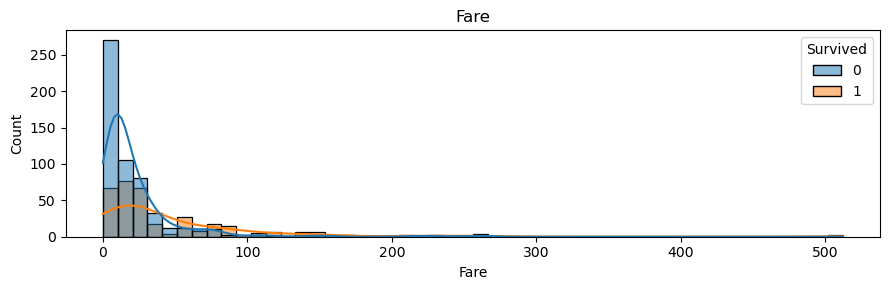

In [482]:
cols = ['Age', 'SibSp', 'Parch', 'Fare']

for x in cols:
    plt.figure(figsize=(9,3), dpi=100)
    sns.histplot(data=df, x=x, bins=50, kde=True, hue='Survived')
    plt.title(f"{x}")
    plt.tight_layout()

Text(0.5, 1.0, 'Correlation')

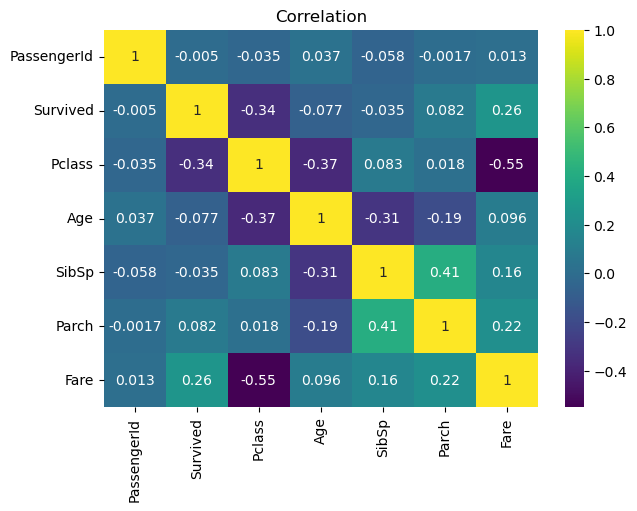

In [483]:
df_corr = df.corr()
plt.figure(figsize=(7,5), dpi=100)
sns.heatmap(data=df_corr, annot=True, cmap='viridis')
plt.title("Correlation")

<Figure size 1000x800 with 0 Axes>

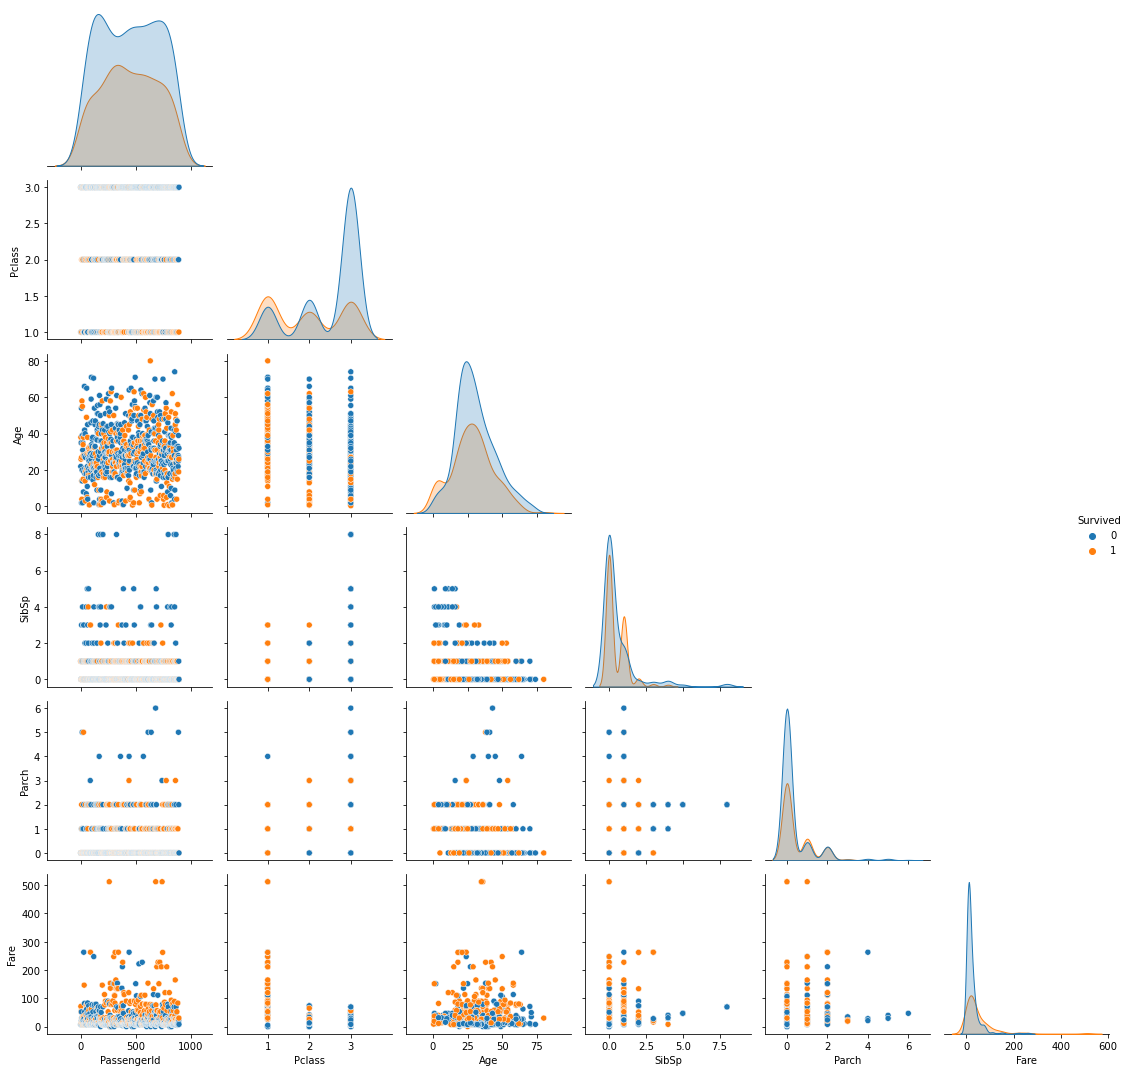

In [193]:
plt.figure(figsize=(10,8), dpi=100)
sns.pairplot(data = df, hue = "Survived", corner=True)
plt.tight_layout()

In [30]:
df.shape

(891, 12)

In [31]:
# Outliers
df = df[(df.Fare <= 300) & ((df.Age <= 75) | df.Age.isnull())]

In [32]:
df.shape

(887, 12)

In [33]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          686
Embarked         2
dtype: int64

In [34]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [35]:
# Features

def feature_engineering(df):
    
    # NAs mask
    df['age_na'] = df['Age'].isnull().astype('category')
    df['embarked_na'] = df['Embarked'].isnull().astype('category')
    df['cabin_na'] = df['Cabin'].isnull().astype('category')

    # Cabin first letter
    df['cabin_0'] = df['Cabin'].apply(lambda x : str(x)[0])

    # Passagers aux alentours
    df['cabin_members'] = df.groupby('cabin_0')['cabin_0'].transform('count')

    # Ticket groupe
    df['ticket_prefix'] = df['Ticket'].apply(lambda x : str(x)[:2] if str(x)[0].isdigit() else str(x)[:1].lower())

    # Group members for each passenger
    df['group_members'] = df.groupby('Ticket')['Ticket'].transform('count')

    # Family members
    df['family_members'] = df['SibSp']+df['Parch']+1

    # alone
    df['alone'] = (df['family_members'] == 1).astype('category')

    # Title
    df['title'] = df['Name'].apply(lambda x : x.split(', ')[-1].split('.')[0])

    df.loc[df['title'] == 'Mlle', 'title'] = 'Miss'
    df.loc[df['title'] == 'Ms', 'title'] = 'Miss'

    df.loc[df['title'] == 'the Countess', 'title'] = 'Mrs'
    df.loc[df['title'] == 'Lady', 'title'] = 'Mrs'
    df.loc[df['title'] == 'Mme', 'title'] = 'Mrs'

    df.loc[df['title'] == 'Major', 'title'] = 'Master'
    df.loc[df['title'] == 'Col', 'title'] = 'Master'
    df.loc[df['title'] == 'Capt', 'title'] = 'Master'
    df.loc[df['title'] == 'Sir', 'title'] = 'Master'
    df.loc[df['title'] == 'Don', 'title'] = 'Master'
    df.loc[df['title'] == 'Jonkheer', 'title'] = 'Master'

    # Nickname
    df['nickname'] = df['Name'].apply(lambda x : '(' in x).astype('category')

    # Child
    df['child'] = df['Age'].apply(lambda x : 1 if x <=8 else 0).astype('category')

    return df

In [36]:
df = feature_engineering(df)

In [37]:
# sorted(df['ticket_prefix'].unique().tolist(), reverse = True)
# df['cabin_members'].value_counts()

In [38]:
cat_cols = ['Sex', 'Embarked', 'Pclass', 
            'age_na', 'embarked_na', 'cabin_na', 
            'cabin_0', 'alone', 'title', 'nickname', 'child', 'ticket_prefix']

num_cols = ['Age', 'Fare'
            , 'SibSp'
            , 'Parch'
            , 'group_members' 
            , 'family_members'
            , 'cabin_members'
            ]
features = cat_cols + num_cols
target = ['Survived']

df = df[features+target]

X = df.drop('Survived', axis=1)
y = df['Survived']

In [39]:
X.shape, y.shape

((887, 19), (887,))

In [40]:
X.head().T

,0,1,2,3,4
Sex,male,female,female,female,male
Embarked,S,C,S,S,S
Pclass,3,1,3,1,3
age_na,False,False,False,False,False
embarked_na,False,False,False,False,False
cabin_na,True,False,True,False,True
cabin_0,n,C,n,C,n
alone,False,False,True,False,True
title,Mr,Mrs,Miss,Mrs,Mr
nickname,False,True,False,True,False


In [41]:
X.isnull().sum()

Sex                 0
Embarked            2
Pclass              0
age_na              0
embarked_na         0
cabin_na            0
cabin_0             0
alone               0
title               0
nickname            0
child               0
ticket_prefix       0
Age               177
Fare                0
SibSp               0
Parch               0
group_members       0
family_members      0
cabin_members       0
dtype: int64

In [42]:
df['Embarked'].value_counts()

S    643
C    165
Q     77
Name: Embarked, dtype: int64

In [43]:
# Imputation - cat
X['Embarked'] = X['Embarked'].fillna('S')

In [44]:
# Imputation - Num
strat_nan_num='mean'
# strat_nan_num='median'

quant_transformer = Pipeline(
    steps=[('Imputer', SimpleImputer(strategy = strat_nan_num))]) 

preprocessor_imp = ColumnTransformer(
    transformers=[('quant', quant_transformer, num_cols),],
    remainder='passthrough', verbose_feature_names_out=False)

X[num_cols] = preprocessor_imp.fit_transform(X[num_cols])

In [45]:
# OH encoding
categorical_transformer = Pipeline(
    steps=[('OHencoder', OneHotEncoder(handle_unknown='ignore', sparse=False, drop = 'first'))
    ])

preprocessor_oh = ColumnTransformer(
    transformers=[('cat', categorical_transformer, cat_cols)],
    remainder='passthrough', 
    verbose_feature_names_out=False)

In [46]:
X_oh = pd.DataFrame(preprocessor_oh.fit_transform(X), columns = preprocessor_oh.get_feature_names_out())

In [47]:
X = X_oh
X = X.set_index(y.index)

In [48]:
# Scaling
scaler = StandardScaler()

scaler.fit(X[num_cols])

X[num_cols] = scaler.transform(X[num_cols])

In [49]:
X.shape

(887, 73)

In [50]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Sex_male,887.0,6.471251e-01,0.478134,0.000000,0.000000,1.000000,1.000000,1.000000
Embarked_Q,887.0,8.680947e-02,0.281715,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_S,887.0,7.271702e-01,0.445665,0.000000,0.000000,1.000000,1.000000,1.000000
Pclass_2,887.0,2.074408e-01,0.405703,0.000000,0.000000,0.000000,0.000000,1.000000
Pclass_3,887.0,5.535513e-01,0.497404,0.000000,0.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
SibSp,887.0,-7.347248e-17,1.000564,-0.475856,-0.475856,-0.475856,0.429904,6.770221
Parch,887.0,2.953919e-17,1.000564,-0.473680,-0.473680,-0.473680,-0.473680,6.962676
group_members,887.0,-1.316747e-16,1.000564,-0.576386,-0.576386,-0.576386,0.158175,3.830980
family_members,887.0,-1.411873e-16,1.000564,-0.561840,-0.561840,-0.561840,0.057231,5.628874


In [ ]:
# PCA
# Elbow method

# explained_variance = []
# range_pc = range(1,8)

# for k in range_pc:
#     # print(f"Fitting PCA for {k} principal components")
#     pca = PCA(n_components=k)
#     pca.fit(X[num_cols])
#     explained_variance.append(np.sum(pca.explained_variance_ratio_))

# plt.figure(figsize=(10,3), dpi=100)
# plt.plot(range_pc, explained_variance, marker='o', markerfacecolor='red', markeredgecolor='black')
# plt.tight_layout()

In [56]:
# # PCA 
# cat_cols_oh = [col for col in X.columns if col not in num_cols]

# pca = PCA(n_components=5)

# X_num_pca = pd.DataFrame(pca.fit_transform(X[num_cols]), columns = feature_names(pca.get_feature_names_out(), X[num_cols]))

# X = pd.concat([X[cat_cols_oh].reset_index(drop=True), X_num_pca.reset_index(drop=True)], axis=1)

# X = X.set_index(y.index)

In [505]:
# # Polynomial features
# cat_cols_oh = [col for col in X.columns if col not in num_cols]

# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# X_num_poly = pd.DataFrame(poly.fit_transform(X[num_cols]), 
#                           columns = feature_names(poly.get_feature_names_out(), X[num_cols]))

# X = pd.concat([X[cat_cols_oh].reset_index(drop=True), X_num_poly.reset_index(drop=True)], axis=1)

# X = X.set_index(y.index)

In [507]:
# cat_cols_new = [col for col in X.columns if col not in num_cols]
# X[cat_cols_new] = X[cat_cols_new].astype(bool)

In [59]:
X.shape

(887, 71)

<a id='section4'></a>
# 4. Modeling & evaluation
<a href='#Summary'>Haut de page</a>

In [508]:
X.to_pickle('./DATA/X.pkl')
y.to_pickle("./DATA/y.pkl")

Logistic regression

In [300]:
%%capture --no-display

clf = LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)

params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

clf_grid = GridSearchCV(clf, 
                        param_grid = params,
                        scoring = 'balanced_accuracy',
                        verbose = 0)

clf_grid.fit(X, y)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='balanced_accuracy')

In [302]:
clf_grid.best_estimator_.get_params()

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'sag',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [509]:
clf = LogisticRegression(penalty = 'l2',
                         C = 1,
                         solver='sag', 
                         random_state=RANDOM_STATE, max_iter=10000)

compute_score(clf, X, y)

0.8309147463975115

SVM

In [518]:
%%capture --no-display

clf = SVC(random_state=RANDOM_STATE, max_iter=10000)

params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.1, 1],
    'class_weight' : ['balanced']
}

clf_grid = GridSearchCV(clf, 
                        param_grid = params,
                        scoring = 'balanced_accuracy',
                        verbose = 0)

clf_grid.fit(X, y)

GridSearchCV(estimator=SVC(max_iter=10000, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced'], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='balanced_accuracy')

In [519]:
clf_grid.best_estimator_.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': 10000,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [520]:
clf = SVC(C = 1, kernel = 'poly', degree = 3, gamma = 'scale', class_weight = 'balanced',
          random_state=RANDOM_STATE, max_iter=10000)

compute_score(clf, X, y)

0.8309337903891322

Random Forest

In [527]:
clf = RandomForestClassifier(n_estimators = 300, 
                             max_depth = 10, 
                             max_features = 'sqrt', 
                             random_state=RANDOM_STATE)

compute_score(clf, X, y)

0.8376944074144609

GradientBoosting

In [61]:
clf = GradientBoostingClassifier(loss = 'deviance',
                                 learning_rate = 0.098,
                                 n_estimators = 460, 
                                 max_depth = 2, 
                                 min_samples_split = 9, 
                                 min_samples_leaf = 2,
                                 max_features = None,
                                 random_state = RANDOM_STATE)

compute_score(clf, X, y)

c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in v

0.8184726718720243

XGB

In [60]:
params = {'n_estimators': 250,
          'max_depth': 10,
          'learning_rate': 0.14411639396009357,
          'subsample': 0.55,
          'min_child_weight': 4.271886768987027,
          'colsample_bytree': 0.6,
          'reg_alpha': 0.18409122037935918,
          'reg_lambda': 0.6862290094219606}

# params = {'n_estimators': 300,
#           'max_depth': 6,
#           'learning_rate': 0.17590344695361748,
#           'subsample': 0.95,
#           'min_child_weight': 0.3,
#           'colsample_bytree': 0.6,
#           'reg_alpha': 0.19024749669307983,
#           'reg_lambda': 4.291587926577438}

clf = xgb.XGBClassifier(**params, 
                        seed = RANDOM_STATE)

compute_score(clf, X, y)

0.8219005903637402

Classifiers aggregation

In [525]:
clf1 = LogisticRegression(penalty = 'l2',
                          C = 1,
                          solver='sag', 
                          random_state=RANDOM_STATE, max_iter=10000)

############################################################################################

clf2 = GradientBoostingClassifier(loss = 'deviance',
                                 learning_rate = 0.098,
                                 n_estimators = 460, 
                                 max_depth = 2, 
                                 min_samples_split = 9, 
                                 min_samples_leaf = 2,
                                 max_features = None,
                                 random_state = RANDOM_STATE)

############################################################################################

params = {'n_estimators': 250,
          'max_depth': 10,
          'learning_rate': 0.14411639396009357,
          'subsample': 0.55,
          'min_child_weight': 4.271886768987027,
          'colsample_bytree': 0.6,
          'reg_alpha': 0.18409122037935918,
          'reg_lambda': 0.6862290094219606}

clf3 = xgb.XGBClassifier(**params, 
                         seed = RANDOM_STATE)

############################################################################################

clf = VotingClassifier(estimators=[('clf1', clf1), 
                                   ('clf2', clf2),
                                   ('clf3', clf3)], 
                                   voting='soft')

compute_score(clf, X, y)

c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in v

0.848955754459468

Train on whole train data and export preprocessors and model

In [459]:
clf.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14411639396009357,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=4.271886768987027, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [460]:
filename = "OUTPUT/preprocessor_oh.pkl"
pickle.dump(preprocessor_oh, open(filename, 'wb'))

filename = "OUTPUT/preprocessor_imp.pkl"
pickle.dump(preprocessor_imp, open(filename, 'wb'))

filename = "OUTPUT/scaler.pkl"
pickle.dump(scaler, open(filename, 'wb'))

filename = "OUTPUT/clf.pkl"
pickle.dump(clf, open(filename, 'wb'))

Apply on test data

In [461]:
df = pd.read_csv('./DATA/test.csv')

In [462]:
df = feature_engineering(df)

In [463]:
X_test = df[features]

In [464]:
filename = "OUTPUT/preprocessor_oh.pkl"
preprocessor_oh = pickle.load(open(filename, 'rb'))

filename = "OUTPUT/preprocessor_imp.pkl"
preprocessor_imp = pickle.load(open(filename, 'rb'))

filename = "OUTPUT/scaler.pkl"
scaler = pickle.load(open(filename, 'rb'))

filename = "OUTPUT/clf.pkl"
clf = pickle.load(open(filename, 'rb'))

In [465]:
X_test[num_cols] = preprocessor_imp.transform(X_test[num_cols])

c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [466]:
X_test_oh = pd.DataFrame(preprocessor_oh.transform(X_test), columns = preprocessor_oh.get_feature_names_out())
X_test = X_test_oh

c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [8, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [467]:
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [468]:
y_pred = clf.predict(X_test)

Export test predictions

In [469]:
output = pd.DataFrame({'PassengerId': df['PassengerId'], 'Survived': y_pred})
output.to_csv('OUTPUT/submission.csv', index=False)